This code generates the model SNe for each model type. 

Check up on Model 4, I think the mixed map has a normalization error. (map built in SNeCO/3.4cModelVisualization)

In [1]:
#import packages and initialize settings
import time
import os
import numpy as np
from astropy.io import fits, ascii
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
from reproject import reproject_interp
import aplpy

plt.rc('text',usetex=True)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

import sys
sys.path.append('./Python')
from nearest import findNearest
from deprojectGalaxy import deproject
from SNeGenerationModels import runModels

In [2]:
#Get Galaxy names, distances, and fits file locations

# Unpack master table to get SNe information
GalaxyData = Table.read('../Data/0.MUSEData.csv', format='csv')
SampleData = Table.read('../Data/2.MUSESampleCat.csv', format='csv') 
SampleData.remove_column("Distance")
SampleData.remove_column("MUSENatMap")
SampleData.remove_column("MUSE150pcMap")
SampleData.remove_column("MUSEHII")
SampleData.remove_column("MUSERes")
SampleData.remove_column("IRACfiles")

database = join(GalaxyData, SampleData, keys = "Galaxy", join_type = 'inner')
centerCoords = [(database["GalRa"][i], database["GalDec"][i]) for i in range(len(database))]   

database[0:8]


Galaxy,Distance,GalRa,GalDec,PosAng,Incl,MUSENatRes,MUSEmapNat,MUSEmap150pc,MUSE_HII_reg,IRAC_files,Supernova,Type,Ra,Dec,InSample
str7,float64,float64,float64,float64,float64,float64,str71,str70,str50,str40,str11,str12,float64,float64,str4
NGC1087,15.85,41.60492,-0.498717,359.1,42.9,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,SN1995V,II,41.61152777777777,-0.4987861111111111,True
NGC1300,18.99,49.920815,-19.411114,278.0,31.8,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,SN2022acko,II,49.91245833333333,-19.39518888888889,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,SN2012fr,Ia,53.40057916666666,-36.12676944444445,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,SN2001du,II,53.3713125,-36.142111111111106,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,SN1983V,Ic,53.381876388888884,-36.14859166666667,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,True
NGC1433,18.63,55.506195,-47.221943,199.7,28.6,0.91,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1433-0.91asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1433-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1433_nebulae_mask_V2.fits,../Data/IRAC/ngc1433_irac1_atGauss4.fits,SN1985P,II,55.52640625,-47.209987222222225,True
NGC1566,17.69,65.00159,-54.93801,214.7,29.5,0.8,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1566-0.80asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1566-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1566_nebulae_mask_V2.fits,../Data/IRAC/ngc1566_irac1_atGauss4.fits,SN2021aefx,Ia,64.9725,-54.94808055555555,True


In [3]:
# Functions
def angDistToPc(x,galDist):
    return(galDist*10**6*np.tan(x*np.pi/180))

def nearestHII(galaxy, HII_file, centerCoord, pa, incl, galDist, SNra, SNdec):
    
    if os.path.isfile(HII_file):

        # read in fits files
        hdu_HII = pyfits.open(HII_file)
        HIIMap  = hdu_HII[0].data

        #Convert x & y pixels to ra and dec
        wcs      = WCS(hdu_HII[0].header, naxis=2)
        naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
        grid     = np.indices((naxis[1],naxis[0]))
        ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)

        #deproject ra and dec to dx and dy
        radius, projang, dx, dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=ra, dec=dec, return_offset=True)

        #flatten data structures 
        f_HII  = HIIMap.flatten()
        f_ra   = ra.flatten()
        f_dec  = dec.flatten()    
        f_dx   = dx.flatten()
        f_dy   = dy.flatten()

        #remove nans
#         keep  = np.where(np.isfinite(f_HII))
        keep  = np.where(f_HII >= 0)
        map_ra    = f_ra[keep]
        map_dec   = f_dec[keep]
        map_HII   = f_HII[keep]
        map_dx    = f_dx[keep]
        map_dy    = f_dy[keep]

        SN_Rad, SN_PA, SN_dx, SN_dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=SNra, dec=SNdec, return_offset=True) 
        
        nearestHII_ang, idx = findNearest(map_dx, SN_dx, map_dy, SN_dy)
        HIIra, HIIdec = map_ra[idx], map_dec[idx]
        nearestHII_pc = angDistToPc(nearestHII_ang,galDist)
        
#         print("Nearest HII region [pc]", nearestHII_pc, galaxy)

    else:
        print("No file for ", galaxy)

        nearestHII_pc = float("nan")
        HIIra = float("nan")
        HIIdec = float("nan")
        
    return(nearestHII_pc, HIIra, HIIdec)


In [4]:
#group sample by galaxy
gal_groups = database.group_by('Galaxy')
galaxies = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

gs, imgs, HIIimgs,IRACimgs, names, types, ras, decs, dists, res = [],[],[],[],[],[],[],[],[],[]
galRa,galDec,galPA,galIncl = [],[],[],[]

for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    gs.append(gal_groups["Galaxy"][indices[i]])
    imgs.append(gal_groups["MUSEmapNat"][indices[i]])
    HIIimgs.append(gal_groups["MUSE_HII_reg"][indices[i]])
    IRACimgs.append(gal_groups["IRAC_files"][indices[i]])
    dists.append(gal_groups["Distance"][indices[i]])
    res.append(gal_groups["MUSENatRes"][indices[i]])
    galRa.append(gal_groups["GalRa"][indices[i]])
    galDec.append(gal_groups["GalDec"][indices[i]])
    galPA.append(gal_groups["PosAng"][indices[i]])
    galIncl.append(gal_groups["Incl"][indices[i]])
    
    #if gal_groups["SN_name"][indices[i]] != "SN1989B" and gal_groups["SN_name"][indices[i]] != "SN1973R":
    # Attach first SN per galaxy to a list
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    # attach additional  SN to list when galaxy has more than one
    while(indices[i] + j < indices[i+1]):    
        #if gal_groups["SN_name"][indices[i]+j] != "SN1989B" and gal_groups["SN_name"][indices[i]+j] != "SN1973R":
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    names.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)

print(gs)
print(ras)

['NGC1087', 'NGC1300', 'NGC1365', 'NGC1433', 'NGC1566', 'NGC1672', 'NGC3627', 'NGC4254', 'NGC4303', 'NGC4321']
[[41.61152777777777], [49.91245833333333], [53.40057916666666, 53.3713125, 53.381876388888884, 53.38349999999999], [55.52640625], [64.9725, 64.99512499999999, 65.0058875], [71.423975, 71.45607916666667], [170.04809375, 170.05796666666666, 170.07957933333336, 170.07072916666667, 170.0592513888889], [184.71836111111114, 184.71066666666667, 184.71690625, 184.70291666666668], [185.48760972222217, 185.47536458333335, 185.50184583333336, 185.4698125, 185.46016458333332, 185.48041875, 185.48991666666666], [185.72488194444443, 185.74543194444445, 185.6970833333333, 185.72892708333336, 185.73393055555553]]


In [5]:
    
# # # run models 1-4 and store results
# galCol, counter, int_mod1, int_mod2, int_mod3, near_mod1, near_mod2, near_mod3 = [],[],[],[],[],[],[],[]

# # for i in range(len(gs)):
# for i in range(0,1):
#     i = 8
    
#     IRAC_hdu = pyfits.open(IRACimgs[i])
#     IRAC_map = IRAC_hdu[0].data
#     # Using MUSE map for coverage
#     img_hdu = pyfits.open(imgs[i])
#     img_map = img_hdu["HA6562_FLUX"].data
    

#     wcs     = WCS(img_hdu["HA6562_FLUX"].header, naxis=2)
#     naxis   = wcs._naxis # size of image naxis[0] = x and [1] = y
#     grid    = np.indices((naxis[1],naxis[0]))
#     ra, dec = wcs.wcs_pix2world(grid[1],grid[0],0)
    
#     IRAC_repro, IRAC_foot = reproject_interp(IRAC_hdu, img_hdu["HA6562_FLUX"].header)

#     f_img = img_map.flatten()
#     f_IRAC = IRAC_repro.flatten() 
#     f_ra  = ra.flatten()
#     f_dec = dec.flatten()
    
# #     keep = np.where(np.isfinite(f_img))
#     keep = np.where(np.isfinite(f_img) & np.isfinite(f_IRAC))
#     IRAC  = f_IRAC[keep]
#     star_ra   = f_ra[keep]
#     star_dec  = f_dec[keep]
    
    
#     raArr1, decArr1, dxArr1, dyArr1, intArr1 = runModels(gs[i], imgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=1)
#     raArr2, decArr2, dxArr2, dyArr2, intArr2 = runModels(gs[i], imgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=2)
#     raArr3, decArr3, dxArr3, dyArr3, intArr3 = runModels(gs[i], imgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=3, starLight = IRAC, starRa = star_ra, starDec = star_dec)
#     #raArr4, decArr4, dxArr4, dyArr4 = runModels(gals[i], mixedFiles[i], coords[i], posAngs[i], inclinations[i], dists[i], modelType=2)

#     n_mod1_dist, n_mod1_ra, n_mod1_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr1, decArr1)
#     n_mod2_dist, n_mod2_ra, n_mod2_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr2, decArr2)
#     n_mod3_dist, n_mod3_ra, n_mod3_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr3, decArr3)
#     #n55_mod4, n65_mod4 = nearestMCMethod(gals[i], images[i], errFiles[i], massFiles[i], coords[i], posAngs[i], inclinations[i], dists[i], raArr4, decArr4)

    
#     if (type(n_mod1_dist) != float and type(n_mod1_dist) != np.float64):
#         for j in range(len(n_mod1_dist)):
#             galCol.append(gs[i])
#             counter.append(j)
#             near_mod1.append(n_mod1_dist[j])
#             near_mod2.append(n_mod2_dist[j])
#             near_mod3.append(n_mod3_dist[j])
#             #n55mod4.append(n55_mod4[j])
#     else:
#         for j in range(100):
#             galCol.append(gals[i])
#             counter.append(j)
#             near_mod1.append(np.float('nan'))
#             near_mod2.append(np.float('nan'))
#             near_mod3.append(np.float('nan'))
#             #n55mod4.append(np.float('nan'))  
            
#     intArr1    = np.nan_to_num(np.clip(intArr1,0,np.max(intArr1)))
#     intArr2    = np.nan_to_num(np.clip(intArr2,0,np.max(intArr2)))
#     intArr3    = np.nan_to_num(np.clip(intArr3,0,np.max(intArr3)))
    
#     int_mod1.append(intArr1)
#     int_mod2.append(intArr2)
#     int_mod3.append(intArr3)
    
#     #plotting code here
#     fig = plt.figure(figsize=(8, 8), facecolor = 'white')

#     f1 = aplpy.FITSFigure(img_map, figure=fig, subplot=(1,3,1))
#     f1.tick_labels.hide()
#     f1.ticks.hide()
#     f1.axis_labels.hide()
#     f1.set_title("Random", fontsize = 16)

#     f2 = aplpy.FITSFigure(img_map, figure=fig,  subplot=(1,3,2))
#     f2.tick_labels.hide()
#     f2.ticks.hide()
#     f2.axis_labels.hide()
#     f2.set_title("Follow H-alpha Distribution", fontsize=16)


#     f3 = aplpy.FITSFigure(IRAC_repro, stretch="log", figure=fig,  subplot=(1,3,3))
#     f3.tick_labels.hide()
#     f3.ticks.hide()
#     f3.axis_labels.hide()
# #     f3.show_contour(massMap, ifr_hdu, levels = [10**5.5, 10**6.5], colors = ["grey", "black"])
#     f3.set_title("Follow Stellar Disk", fontsize=16)

    
# #     f4 = aplpy.FITSFigure(mixMap, mixhdu, figure=fig,  subplot=(2,2,4))
# #     f4.tick_labels.hide()
# #     f4.ticks.hide()
# #     f4.axis_labels.hide()
# # #     f4.show_contour(massMap, ifr_hdu, levels = [10**5.5, 10**6.5], colors = ["grey", "black"])
# #     f4.set_title("Hybrid", fontsize=16)

    
#     f1.show_colorscale(vmin=0, pmax=95, cmap='magma', stretch='linear')
#     f1.set_nan_color('black')

#     f2.show_colorscale(vmin=0, pmax=95, cmap='magma', stretch='linear')
#     f2.set_nan_color('black')

#     f3.show_colorscale(vmin=0, pmax=95, cmap='magma', stretch='linear')
#     f3.set_nan_color('black')

# #     f4.show_colorscale(vmin=0, pmax=95, cmap='magma', stretch='linear')
# #     f4.set_nan_color('black')
    
#     fig.tight_layout()

#     xArr1, yArr1 = wcs.wcs_world2pix(raArr1,decArr1,0)
#     xArr2, yArr2 = wcs.wcs_world2pix(raArr2,decArr2,0)
#     xArr3, yArr3 = wcs.wcs_world2pix(raArr3,decArr3,0)
# #     xArr4, yArr4 = wcs.wcs_world2pix(raArr4,decArr4,0)

#     for k in range(len(dxArr3)):
#         f1.add_label(float(xArr1[k]), float(yArr1[k]), text='*', color='black', size = 22, weight="bold")
#         f2.add_label(float(xArr2[k]), float(yArr2[k]), text='*', color="black", weight="bold", size=22)
#         f3.add_label(float(xArr3[k]), float(yArr3[k]), text='*', color="black", weight="bold", size=22)
# #         f4.add_label(float(xArr4[k]), float(yArr4[k]), text='*', color="black", fontsize = 22, weight="bold")
#         f1.add_label(float(xArr1[k]), float(yArr1[k]), text='*', color='lime', size = 20)
#         f2.add_label(float(xArr2[k]), float(yArr2[k]), text='*', color="lime", size=20)
#         f3.add_label(float(xArr3[k]), float(yArr3[k]), text='*', color="lime", size=20)
# #         f4.add_label(float(xArr4[k]), float(yArr4[k]), text='*', color="lime", fontsize = 20)

#     figName = "../Figures/" + gs[i] + "Models.png"
#     fig.savefig(figName, dpi = 300)

    
# int_mod1 = np.hstack(int_mod1)
# int_mod2 = np.hstack(int_mod2)
# int_mod3 = np.hstack(int_mod3)
    

# # cdfSM_mod1 = np.sort(smMod1)/np.sum(smMod1)
# # cdfSM_mod2 = np.sort(smMod2)/np.sum(smMod2) 
# # cdfSM_mod3 = np.sort(smMod3)/np.sum(smMod3)
    
# # results = Table({"Galaxy": galCol,
# #                 "ModelNum": counter,
# #                 "near_Mod1_dist": near_mod1,
# #                 "near_Mod2_dist": near_mod2,
# #                 "near_Mod3_dist": near_mod3,
# #                 "intMod1":int_mod1,
# #                 "intMod2":int_mod2,
# #                 "intMod3":int_mod3})

# # results.write("../Data/AllModels.csv", format = "csv", overwrite = True)

        
        
    

In [6]:
# print(len(galCol))
# print(len(counter))
# print(len(near_mod1))
# print(len(near_mod2))
# print(len(near_mod3))
# np.hstack(int_mod1)
# print(len(smMod2))
# print(len(cdfSM_mod3))

In [7]:
import math
# get the real SN sample's distances (copied over from 1c)
realSNe = [0,130,524,88,0,201,0,120,100,0,0,5,0,0,29,0,0,11,0,7,0,0,44,0,36,22,14,214,63,8,13,0,0]

# Here make CDFs of the distances from the generated SNe to the nearest HII regions
modelResults = Table.read("../Data/AllModels.csv", format = 'csv')

nm1 = [x for x in modelResults["near_Mod1_dist"] if math.isnan(x) == False]
nm2 = [x for x in modelResults["near_Mod2_dist"] if math.isnan(x) == False]
nm3 = [x for x in modelResults["near_Mod3_dist"] if math.isnan(x) == False]

# nm4 = np.concatenate((nm2[0:1914],nm3[1914:]))


In [8]:
def findNear(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def makeCDFs(array):
    count, bins_count = np.histogram(array, bins=len(array))
    xVals = bins_count[1:]
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return(xVals, cdf)

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)


In [9]:
#original idea for how this should work
def randomPull(modelArr, numSNe=33, numRuns=1000):
    # pull intensity vals at locations of 33 model SNe 1000 times.    
    allPulls = []
    # iterate over 1000 runs
    for i in range(numRuns):
        singlePulls = []
        # iterate over number of SNe
        for j in range(numSNe):
            # choose a random distance from model SNe
            val = np.random.choice(modelArr)
            singlePulls.append(val)
        # sort the model SNe distances and save
        sortedPulls = np.sort(singlePulls)
        allPulls.append(sortedPulls)
        
        
        
    # determine 50th percentile array by finding 1000 closest values to each x in model array       
    allPer16Vals, allPer50Vals, allPer84Vals = [],[],[]
    for i in range(len(modelArr)):
        SNlocVals=[]
        for j in range(numRuns):
            # find the actual distance value that is the closest to the generated model values 
            SNlocVals.append(findNear(allPulls[j], modelArr[i]))
            
            
            
    # now find 16-84th percentiles from each of these local distributions around x value    
        locVals = np.sort(SNlocVals)
        if(np.sum(locVals)==0.0):
            sumVals = locVals
        else:
            sumVals = locVals/np.sum(locVals)
        normVals = np.cumsum(sumVals)

        
        per16Vals = np.percentile(locVals,16)
        allPer16Vals.append(per16Vals)
        per50Vals = np.percentile(locVals,50)
        allPer50Vals.append(per50Vals)
        per84Vals = np.percentile(locVals,84)
        allPer84Vals.append(per84Vals)

    return(allPer16Vals, allPer50Vals, allPer84Vals)

In [10]:
nSMm1_16, nSMm1_50, nSMm1_84 = randomPull(nm1)
nSMm2_16, nSMm2_50, nSMm2_84 = randomPull(nm2)
nSMm3_16, nSMm3_50, nSMm3_84 = randomPull(nm3)
# nSMm4_16, nSMm4_50, nSMm4_84 = randomPull(nm4)


# want to recreate ecdf plot with pyplot    
SNe,  ySNe  = ecdf(realSNe)
mod1, ymod1 = makeCDFs(nm1)
mod2, ymod2 = makeCDFs(nm2)
mod3, ymod3 = makeCDFs(nm3)
# mod4, ymod4 = makeCDFs(nSMm4)

mod1_16, ymod1_16 = makeCDFs(nSMm1_16)
mod1_50, ymod1_50 = makeCDFs(nSMm1_50)
mod1_84, ymod1_84 = makeCDFs(nSMm1_84)
mod2_16, ymod2_16 = makeCDFs(nSMm2_16)
mod2_50, ymod2_50 = makeCDFs(nSMm2_50)
mod2_84, ymod2_84 = makeCDFs(nSMm2_84)
mod3_16, ymod3_16 = makeCDFs(nSMm3_16)
mod3_50, ymod3_50 = makeCDFs(nSMm3_50)
mod3_84, ymod3_84 = makeCDFs(nSMm3_84)
# mod4_16, ymod4_16 = makeCDFs(nSMm4_16)
# mod4_50, ymod4_50 = makeCDFs(nSMm4_50)
# mod4_84, ymod4_84 = makeCDFs(nSMm4_84)

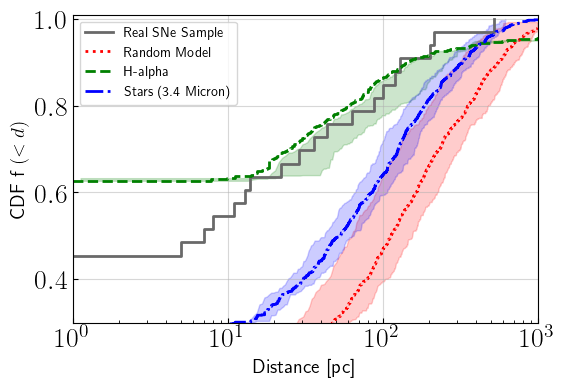

In [11]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(6,4))

sns.ecdfplot(realSNe, color = "dimgrey",  label="Real SNe Sample", ax=ax,lw=2)
sns.ecdfplot(nm1, label="Random Model", color='red', ls=":",ax=ax,lw=2)
sns.ecdfplot(nm2, label="H-alpha", color='green', ls="--",lw=2,ax=ax)
sns.ecdfplot(nm3, label="Stars (3.4 Micron)", color='blue', ls="-.",lw=2,ax=ax)
# ax[0].plot(mod4, ymod4, label="Hybrid (76% gas + 24% stars)", color='purple', ls="-",lw=2)
ax.fill_between(x=mod1_50, y1=ymod1_16,y2=ymod1_84, color='red', alpha=0.2)
ax.fill_between(x=mod2_50, y1=ymod2_16,y2=ymod2_84, color='green', alpha=0.2)
ax.fill_between(x=mod3_50, y1=ymod3_16,y2=ymod3_84, color='blue', alpha=0.2)
# ax[0].fill_between(x=mod4_50, y1=ymod4_16,y2=ymod4_84, color='purple', alpha=0.2)
ax.set_xscale('log')
ax.set_ylim (0.3,1.01)
ax.set_xlim(1,1000)
ax.legend(loc='best')

# sns.ecdfplot(nSMIa,color = "black", ls=':', label="Real SNe Ia", ax=ax[1],lw=2)
# sns.ecdfplot(nSMII,color = "black", ls='-',  label="Real SNe II", ax=ax[1],lw=2)
# sns.ecdfplot(nSMIbc,color = "black", ls='--',  label="Real SNe Ibc", ax=ax[1],lw=2)
# sns.ecdfplot(nSMunc,color = "black", ls='-.',  label="Real Unclassified", ax=ax[1],lw=2)

# ax[1].plot(mod1, ymod1, color='red', ls=":",lw=2)
# ax[1].plot(mod2, ymod2, color='green', ls="--",lw=2)
# ax[1].plot(mod3, ymod3, color='blue', ls="-.",lw=2)
# # ax[1].plot(mod4, ymod4, color='purple', ls="-",lw=2)
# ax[1].fill_between(x=mod1_50, y1=ymod1_16,y2=ymod1_84, color='red', alpha=0.2)
# ax[1].fill_between(x=mod2_50, y1=ymod2_16,y2=ymod2_84, color='green', alpha=0.2)
# ax[1].fill_between(x=mod3_50, y1=ymod3_16,y2=ymod3_84, color='blue', alpha=0.2)
# # ax[1].fill_between(x=mod4_50, y1=ymod4_16,y2=ymod4_84, color='purple', alpha=0.2)
# ax[1].set_xscale('log')
# ax[1].set_ylim (0.3,1.01)
# ax[1].set_xlim(60,5000)

# ax[1].legend(loc='best')

ax.tick_params(axis = "both", which = "both", direction = "in")
# ax[1].tick_params(axis = "both", which = "both", direction = "in")

plt.xlabel("Distance [pc]", fontsize = 14)
ax.set_ylabel(r"CDF f $(< d)$", fontsize = 14)
# ax[1].set_ylabel("CDF f (< d)", fontsize = 14)
ax.grid(which='major', alpha=0.5)
# ax[1].grid(which='major', alpha=0.5)
fig.savefig("../Figures/DistanceCDF.png", dpi=300)
plt.show()
plt.close()